In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
import logging

import numpy as np
import xarray as xr
import pandas as pd

from matplotlib import pyplot as plt, animation
import cartopy.crs as ccrs
import cartopy

# This is needed to display graphics calculated outside of jupyter notebook
from IPython.display import HTML, display

plt.rc("figure", figsize=(12,10))
plt.rc("font", size=14)

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=8, silence_logs='error')
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38187 instead
  warnings.warn(


<Client: 'inproc://137.129.155.67/25606/1' processes=1 threads=8, memory=78.61 GiB>

In [2]:
! test -d ../images/Python_Animation && rm -rf ../images/Python_Animation/* || mkdir -p ../images/Python_Animation

In [3]:
day1 = '2009-08-21'
day2 = '2009-09-04'
specificDay = '2009-09-01T12'

In [4]:
year = 2009

indir_anom = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/'

ds_u = xr.open_mfdataset(indir_anom + '/u/anom_u_brut_ERA5_3H*' + str(year) + '.nc', chunks = {'time' : 1}, parallel=True, concat_dim="level")
_ds_u = xr.open_mfdataset(indir_anom + '/u/anom_u_z850_brut_ERA5_3H*' + str(year) + '.nc', chunks = {'time' : 1}, parallel=True, concat_dim="level")
ds_u = xr.concat([ds_u.sel(level = 200), _ds_u], dim = "level")

ds_v = xr.open_mfdataset(indir_anom + '/v/anom_v_brut_ERA5_3H*' + str(year) + '.nc', chunks = {'time' : 1}, parallel=True, concat_dim="level")
_ds_v = xr.open_mfdataset(indir_anom + '/v/anom_v_z850_brut_ERA5_3H*' + str(year) + '.nc', chunks = {'time' : 1}, parallel=True, concat_dim="level")
ds_v = xr.concat([ds_v.sel(level = 200), _ds_v], dim = "level")

indir_data_FILTERED = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/'
filenames = np.arange(2009,2010)

datasets = []
for f in filenames:
    print(indir_data_FILTERED + 'TCWV/* ' + str(f) + '*.nc')
    ds = xr.open_mfdataset(indir_data_FILTERED + 'TCWV/*' + str(f) + '*.nc', chunks={'time': 150})
    datasets.append(ds)
ds_anom_TCWV = xr.concat(datasets, dim='time', coords='minimal', compat='override')
_ds_anom_TCWV = ds_anom_TCWV.assign_coords(lon=(((ds_anom_TCWV.lon + 180) % 360) - 180)).sortby('lon')
_ds_anom_TCWV = _ds_anom_TCWV.sel(time= slice(day1, day2), lon = slice(-90,40))
_ds_anom_TCWV

/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/TCWV/* 2009*.nc


/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key

<xarray.Dataset>
Dimensions:      (time: 120, lat: 321, lon: 521)
Coordinates:
  * time         (time) datetime64[ns] 2009-08-21 ... 2009-09-04T21:00:00
  * lat          (lat) float64 40.0 39.75 39.5 39.25 ... -39.5 -39.75 -40.0
  * lon          (lon) float32 -90.0 -89.75 -89.5 -89.25 ... 39.5 39.75 40.0
Data variables:
    TCWV_Kelvin  (time, lat, lon) float64 dask.array<chunksize=(94, 321, 521), meta=np.ndarray>
    TCWV_Rossby  (time, lat, lon) float64 dask.array<chunksize=(94, 321, 521), meta=np.ndarray>
    TCWV_MJO     (time, lat, lon) float64 dask.array<chunksize=(94, 321, 521), meta=np.ndarray>
    TCWV_MRG     (time, lat, lon) float64 dask.array<chunksize=(94, 321, 521), meta=np.ndarray>
    TCWV_EIG     (time, lat, lon) float64 dask.array<chunksize=(94, 321, 521), meta=np.ndarray>
    TCWV_WIG     (time, lat, lon) float64 dask.array<chunksize=(94, 321, 521), meta=np.ndarray>
    TCWV_TD      (time, lat, lon) float64 dask.array<chunksize=(94, 321, 521), meta=np.ndarray>
    TCWV_LF      (time, lat, lon) float64 dask.array<chunksize=(94, 321, 521), meta=np.ndarray>

In [8]:
ds = xr.merge([ds_u.sel(time = slice(day1, day2)),ds_v.sel(time = slice(day1, day2))])
ds = ds.assign_coords(longitude = (((ds.longitude + 180) % 360) - 180)).sortby('longitude')
ds = ds.isel(latitude = slice(0,None,8), longitude = slice(0,None,8)).sel(longitude = slice(-90, 40))
ds

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key

<xarray.Dataset>
Dimensions:    (level: 2, longitude: 66, latitude: 41, time: 120)
Coordinates:
  * level      (level) int32 200 850
  * longitude  (longitude) float32 -90.0 -88.0 -86.0 -84.0 ... 36.0 38.0 40.0
  * latitude   (latitude) float32 40.0 38.0 36.0 34.0 ... -36.0 -38.0 -40.0
  * time       (time) datetime64[ns] 2009-08-21 ... 2009-09-04T21:00:00
Data variables:
    u_ano      (time, latitude, longitude, level) float64 dask.array<chunksize=(1, 41, 66, 1), meta=np.ndarray>
    v_ano      (time, latitude, longitude, level) float64 dask.array<chunksize=(1, 41, 66, 1), meta=np.ndarray>

In [9]:
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-10.0, 
                         max_latitude=30.0,
                         globe=None)
# plt.rc("figure", figsize=(20,14))
cmap ='BrBG'
vmin, vmax = -5, +5
colorbar = {'label': 'TCWV $kg.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'}

In [10]:
ds.time.size

120

# Vent avec l'onde de Kelvin

## à 850 hPA

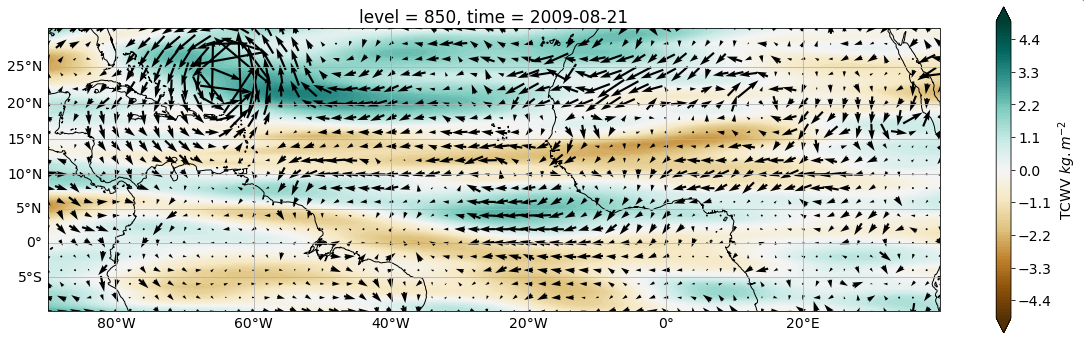

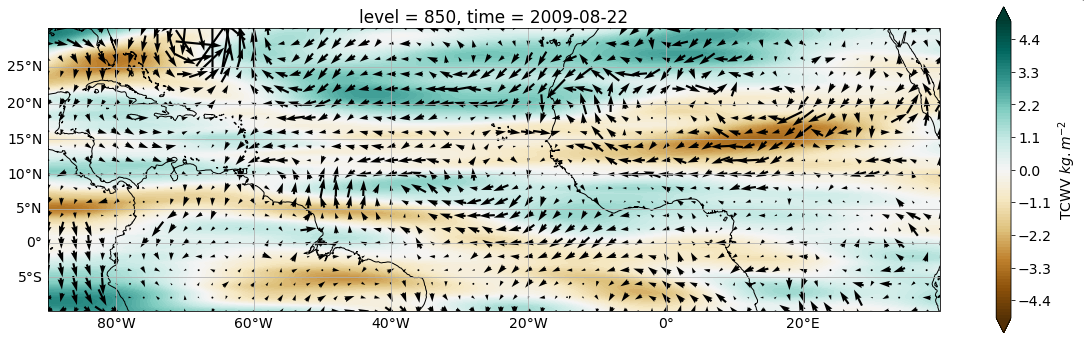

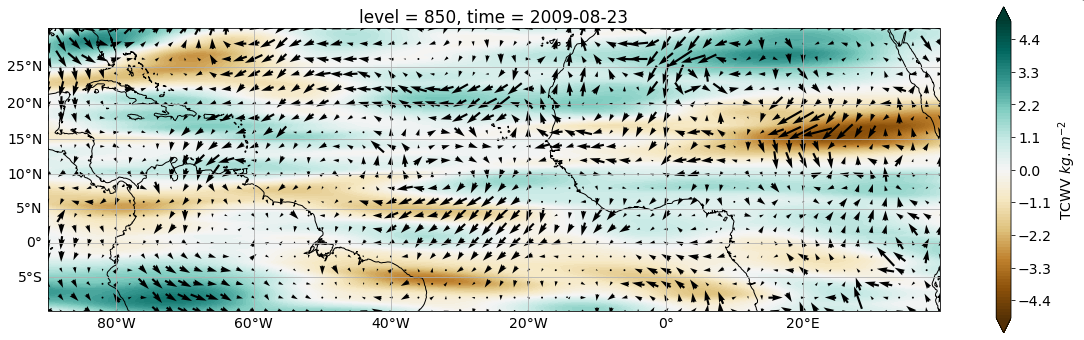

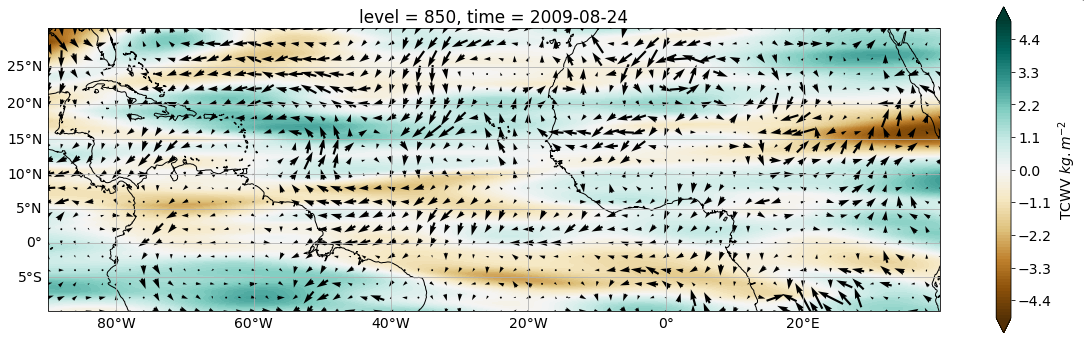

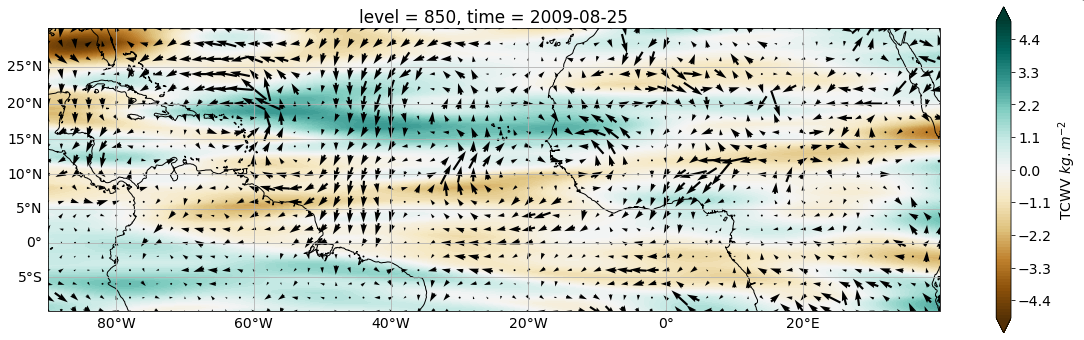

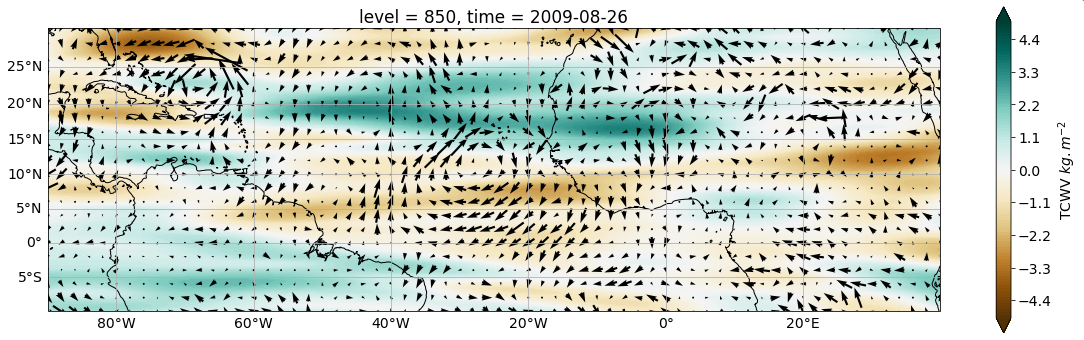

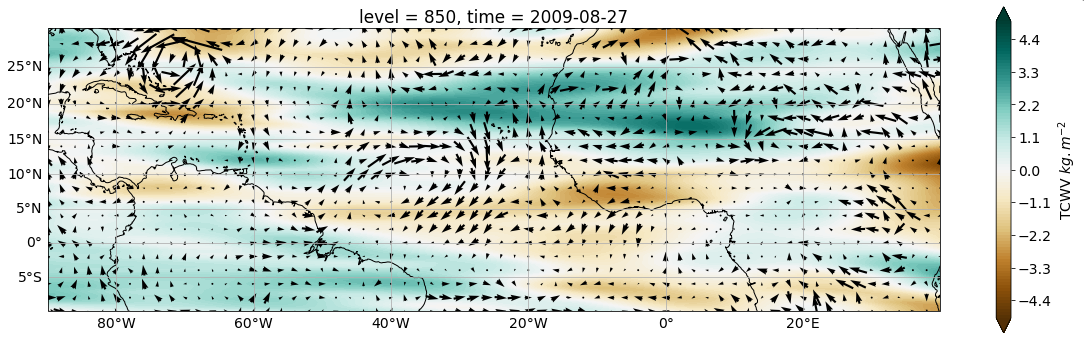

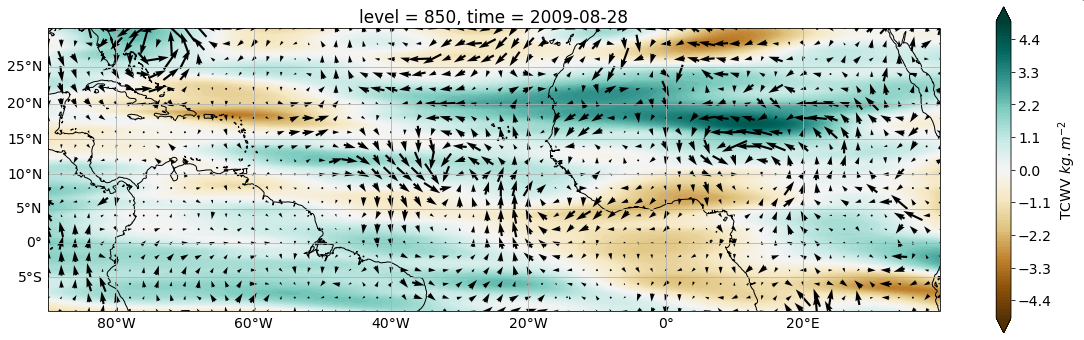

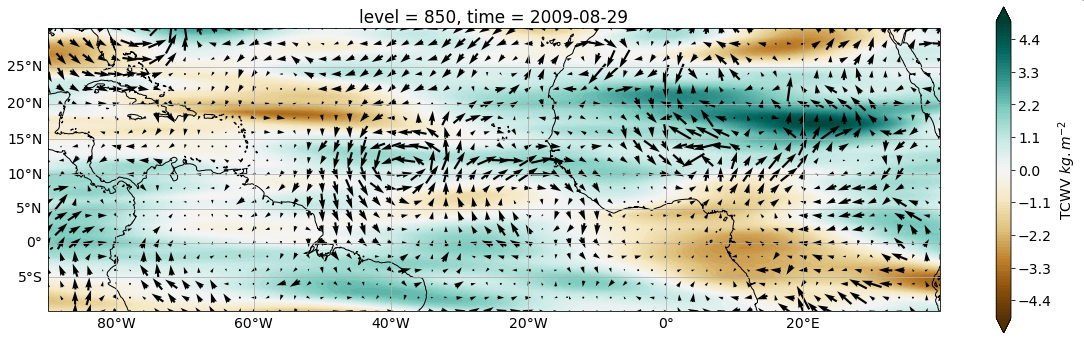

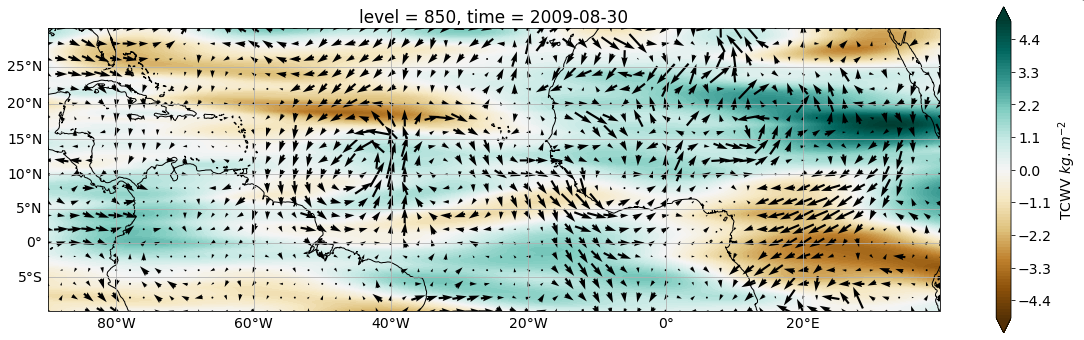

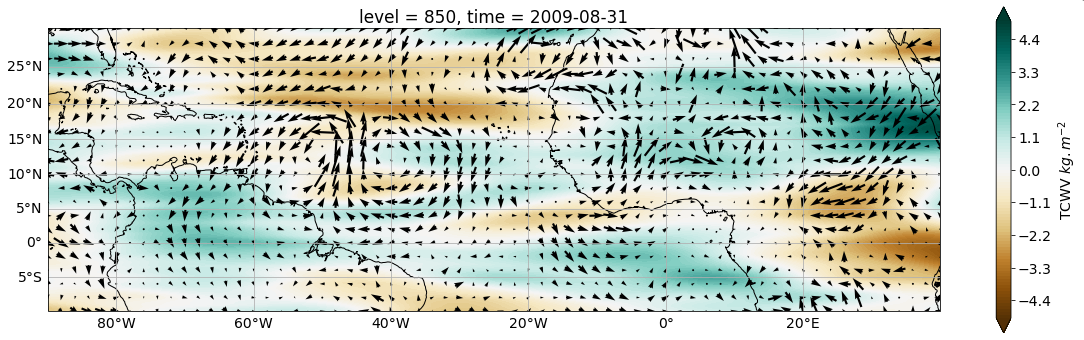

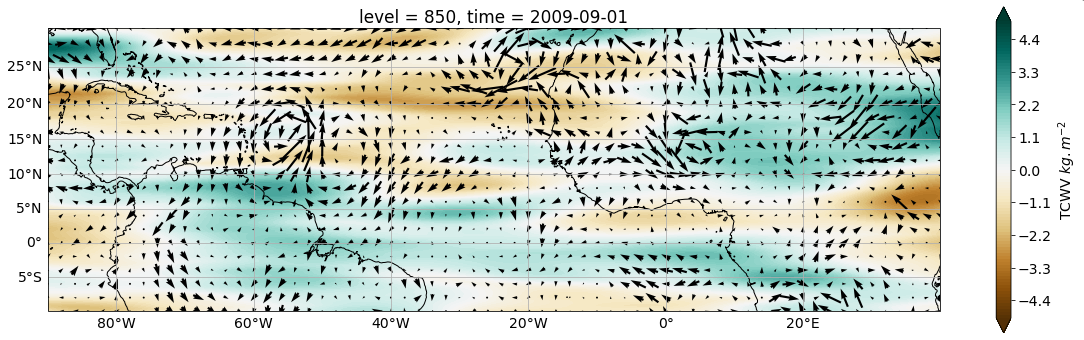

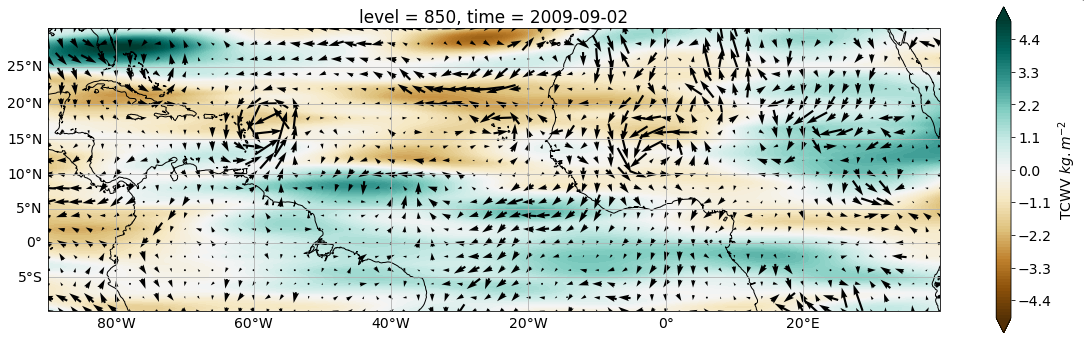

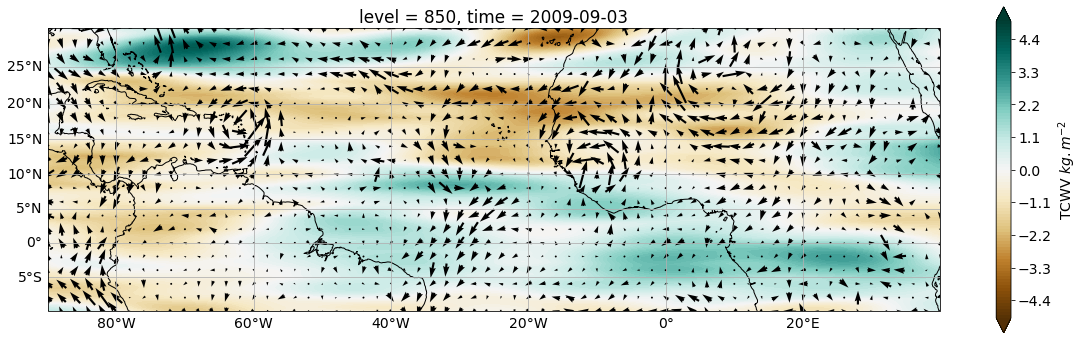

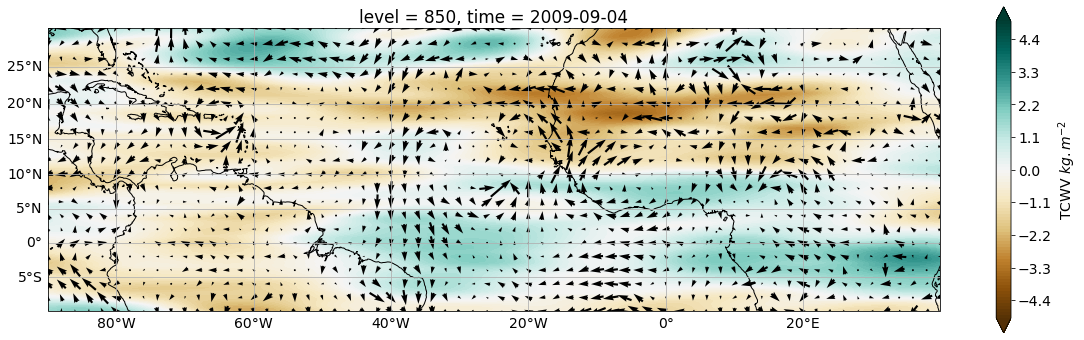

In [7]:
i = 4

#####################################################################################


for i in range(0,ds.time.size,8):
    fig, axis = plt.subplots( 1, 1, 
        figsize=(20,6), subplot_kw={'projection': map_proj})

    _ds_anom_TCWV['TCWV_Kelvin'].isel(time = i).plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                        transform=ccrs.PlateCarree(),
                        cmap=cmap ,
                        cbar_kwargs=colorbar)


    ds.isel(level=1, time = i).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                        transform=ccrs.PlateCarree(), ax=axis, 
                                        scale = 400)

    axis.coastlines()
    gl = axis.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    plt.show()

In [12]:
for i in range(ds.time.size):
    fig, axis = plt.subplots( 1, 1, 
        figsize=(20,6), subplot_kw={'projection': map_proj})

    _ds_anom_TCWV['TCWV_Kelvin'].isel(time = i).plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                        transform=ccrs.PlateCarree(),
                        cmap=cmap ,
                        cbar_kwargs=colorbar)


    ds.isel(level=1, time = i).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                        transform=ccrs.PlateCarree(), ax=axis, 
                                        scale = 400)

    axis.coastlines()
    gl = axis.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    plt.title("Time = " + str(ds.coords['time'].values[i])[:13])
    plt.savefig(f"../images/Python_Animation/Python_Animation_01_frame_{i:04}.png")
    plt.close()
    
! convert ../images/Python_Animation/Python_Animation_01_frame*png ../images/Python_Animation/Python_Animation_01.gif
display(HTML("<img src='../images/Python_Animation/Python_Animation_01.gif' />"))

## à 200 hPA

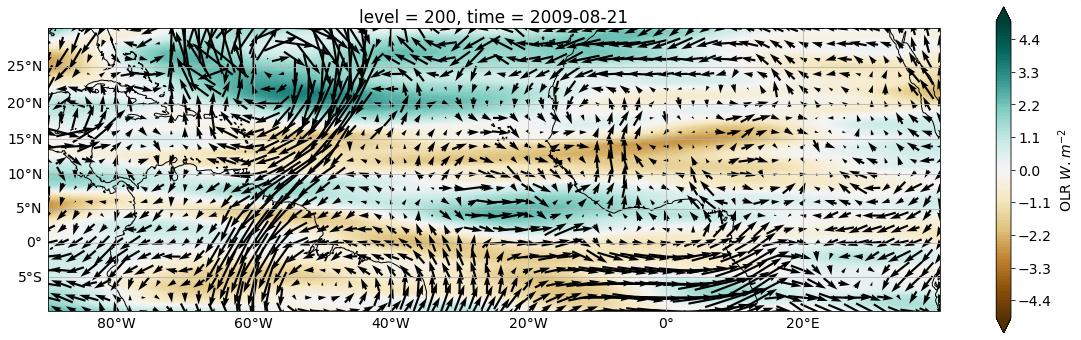

In [ ]:
#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'}


for i in range(0,ds.time.size,8):

    fig, axis = plt.subplots( 1, 1, 
        figsize=(20,6), subplot_kw={'projection': map_proj})

    _ds_anom_TCWV['TCWV_Kelvin'].isel(time = i).plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                        transform=ccrs.PlateCarree(),
                        cmap=cmap ,
                        cbar_kwargs=colorbar)


    ds.isel(level=0).isel(time = i).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                        transform=ccrs.PlateCarree(), ax=axis, 
                                        scale = 400)

    axis.coastlines()
    gl = axis.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    plt.show()

# Vent avec l'onde de Rossby 

## à 850 hPa

In [ ]:
#####################################################################################
for i in range(0,ds.time.size,8):

    fig, axis = plt.subplots( 1, 1, 
        figsize=(20,6), subplot_kw={'projection': map_proj})

    _ds_anom_TCWV['TCWV_Rossby'].isel(time = i).plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                        transform=ccrs.PlateCarree(),
                        cmap=cmap ,
                        cbar_kwargs=colorbar)


    ds.isel(level=1).isel(time = i).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                        transform=ccrs.PlateCarree(), ax=axis, 
                                        scale = 200)

    axis.coastlines()
    gl = axis.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    plt.show()

## à 200 hPa

In [ ]:
#####################################################################################

for i in range(0,ds.time.size,8):

    fig, axis = plt.subplots( 1, 1, 
        figsize=(20,6), subplot_kw={'projection': map_proj})

    _ds_anom_TCWV['TCWV_Rossby'].isel(time = i).plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                        transform=ccrs.PlateCarree(),
                        cmap=cmap ,
                        cbar_kwargs=colorbar)


    ds.isel(level=0).isel(time = i).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                        transform=ccrs.PlateCarree(), ax=axis, 
                                        scale = 400)

    axis.coastlines()
    gl = axis.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    plt.show()

# Onde de MRG

## à 850 hPa

In [ ]:
#####################################################################################

for i in range(0,ds.time.size,8):

    fig, axis = plt.subplots( 1, 1, 
       figsize=(20,6), subplot_kw={'projection': map_proj})

    _ds_anom_TCWV['TCWV_MRG'].isel(time = i).plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                        transform=ccrs.PlateCarree(),
                        cmap=cmap ,
                        cbar_kwargs=colorbar)


    ds.isel(level=1).isel(time = i).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                        transform=ccrs.PlateCarree(), ax=axis, 
                                        scale = 200)

    axis.coastlines()
    gl = axis.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    plt.show()

## à 200 hPA

In [ ]:
#####################################################################################

for i in range(0,ds.time.size,8):

    fig, axis = plt.subplots( 1, 1, 
       figsize=(20,6), subplot_kw={'projection': map_proj})

    _ds_anom_TCWV['TCWV_MRG'].isel(time = i).plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                        transform=ccrs.PlateCarree(),
                        cmap=cmap ,
                        cbar_kwargs=colorbar)


    ds.isel(level=0).isel(time = i).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                        transform=ccrs.PlateCarree(), ax=axis, 
                                        scale = 400)

    axis.coastlines()
    gl = axis.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    plt.show()

# EIG

# à 850 hPa

In [ ]:
#####################################################################################
for i in range(0,ds.time.size,8):

    fig, axis = plt.subplots( 1, 1, 
        figsize=(20,6), subplot_kw={'projection': map_proj})

    _ds_anom_TCWV['TCWV_EIG'].isel(time = i).plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                        transform=ccrs.PlateCarree(),
                        cmap=cmap ,
                        cbar_kwargs=colorbar)


    ds.isel(level=1).isel(time = i).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                        transform=ccrs.PlateCarree(), ax=axis, 
                                        scale = 200)

    axis.coastlines()
    gl = axis.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    plt.show()

# à 200 hPA

In [ ]:
#####################################################################################

for i in range(0,ds.time.size,8):

    fig, axis = plt.subplots( 1, 1, 
        figsize=(20,6), subplot_kw={'projection': map_proj})

    _ds_anom_TCWV['TCWV_EIG'].isel(time = i).plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                        transform=ccrs.PlateCarree(),
                        cmap=cmap ,
                        cbar_kwargs=colorbar)


    ds.isel(level=0).isel(time = i).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                        transform=ccrs.PlateCarree(), ax=axis, 
                                        scale = 400)

    axis.coastlines()
    gl = axis.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    plt.show()

# WIG

# à 850 hPA

In [ ]:
#####################################################################################

for i in range(0,ds.time.size,8):

    fig, axis = plt.subplots( 1, 1, 
        figsize=(20,6), subplot_kw={'projection': map_proj})

    _ds_anom_TCWV['TCWV_WIG'].isel(time = i).plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                        transform=ccrs.PlateCarree(),
                        cmap=cmap ,
                        cbar_kwargs=colorbar)


    ds.isel(level=1).isel(time = i).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                        transform=ccrs.PlateCarree(), ax=axis, 
                                        scale = 200)

    axis.coastlines()
    gl = axis.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    plt.show()

# à 200 hPA

In [ ]:
#####################################################################################

for i in range(0,ds.time.size,8):

    fig, axis = plt.subplots( 1, 1, 
      figsize=(20,6), subplot_kw={'projection': map_proj})

    _ds_anom_TCWV['TCWV_WIG'].isel(time = i).plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                        transform=ccrs.PlateCarree(),
                        cmap=cmap ,
                        cbar_kwargs=colorbar)


    ds.isel(level=0).isel(time = i).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                        transform=ccrs.PlateCarree(), ax=axis, 
                                        scale = 200)

    axis.coastlines()
    gl = axis.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    plt.show()